### Testing Raw Cible WB

## Part 1: Setup and Data Loading


In [1]:
### Dowload and install dependencies for the project
# %matplotlib inline
%pip install setuptools wheel cython statsmodels
%pip install kaleido jinja2


[notice] A new release of pip available: 22.2.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip available: 22.2.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
### ====================
### Importing libraries
### ====================
%load_ext autoreload
%autoreload 2
import sys
import openpyxl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

#import shap
import os
import warnings

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
### ====================
### Set up visualization and warnings
### ====================
warnings.filterwarnings('ignore')
plt.style.use('ggplot')
pd.set_option('display.max_columns', None)
# sns.set_palette('viridis')


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


2025-06-06 14:58:25.306817: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-06-06 14:58:25.561926: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2025-06-06 14:58:25.561967: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2025-06-06 14:58:25.613213: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-06 14:58:27.136571: W tensorflow/stream_executor/platform/de

In [3]:
### ====================
### File paths
###  ===================
# Create directories for model saving
models_dir = '../../models'
for model_type in ['simple_models', 'ml_models', 'dl_models']:
    models_dir = os.path.join(models_dir, model_type)
    os.makedirs(models_dir, exist_ok=True)

# Load Excel file
maquettes_path = "../../data/raw/"

maquettes= ["RawData-Cibles.xlsx"]
for maquette in maquettes:
    maquettes_path = os.path.join(maquettes_path, maquette)
sheets = ["Mur", "Sols", "Poutre", "Poteaux"]  # Adjusted based on your description

processed_data_path = os.path.join("../../data/processed/", os.path.splitext(maquette)[0])
os.makedirs(processed_data_path, exist_ok=True)


## Import Pythoon Modules
sys.path.append("../../module_python")

### Export Plots
# Create a folder for plots specific to the current maquette
plots_folder = os.path.join("../../plot", os.path.splitext(maquette)[0])
os.makedirs(plots_folder, exist_ok=True)


In [4]:
import excel_data_loader
data = excel_data_loader.load_data(maquettes_path)


# Access the DataFrames
murs_df = data.get('Murs')
sols_df = data.get('Sols')
poutres_df = data.get('Poutres')
poteaux_df = data.get('Poteaux')

# Display basic info
print("Murs DataFrame Shape:", murs_df.shape)
print("Sols DataFrame Shape:", sols_df.shape)
print("Poutres DataFrame Shape:", poutres_df.shape)
print("Poteaux DataFrame Shape:", poteaux_df.shape)

# Display column names
for sheet_name, df in data.items():
    print(f"\n{sheet_name} DataFrame Preview:")
    print(df.columns)

Data loaded successfully from the Excel file.
Murs DataFrame Shape: (312, 96)
Sols DataFrame Shape: (107, 94)
Poutres DataFrame Shape: (246, 100)
Poteaux DataFrame Shape: (68, 87)

Murs DataFrame Preview:
Index(['Id', '011EC_Lot', '012EC_Ouvrage', '013EC_Localisation',
       '014EC_Mode Constructif', 'Nom', 'Hauteur', 'Epaisseur', 'AI', 'AS',
       'Sols en intersection', 'Sols coupés (u)', 'Sols coupés (Ids)',
       'Sols coupants (u)', 'Sols coupants (Ids)', 'Sol au-dessus',
       'Sol en-dessous', 'Fenêtres', 'Portes', 'Ouvertures', 'Murs imbriqués',
       'Mur multicouche', 'Mur empilé', 'Profil modifié', 'Image', 'Catégorie',
       'Section', 'Type prédéfini d'IFC', 'Exporter au format IFC sous',
       'Exporter au format IFC', 'IfcGUID', 'A une association',
       'Enrobage d'armature - Autres faces',
       'Enrobage d'armature - Face intérieure',
       'Enrobage d'armature - Face extérieure', 'Variantes',
       'Extension inférieure', 'Extension supérieure', 'Volume',

## Part 2: Data Preprocessing and Relationship Mapping


📂 Loading and sanitizing Excel file...
✅ Murs: Sanitized 31 columns
✅ Sols: Sanitized 23 columns
✅ Poutres: Sanitized 23 columns
✅ Poteaux: Sanitized 26 columns
🔍 COLUMN MAPPING ANALYSIS

📊 DataFrame Column Counts:
   Murs: 31 columns
   Sols: 23 columns
   Poutres: 23 columns
   Poteaux: 26 columns

🌐 Total Unique Columns Across All DataFrames: 103

🤝 Common Columns (found in multiple DataFrames): 0

🔗 Relationship Columns (coupés/coupants mappings): 15
   'Mur_Sols_coupants_Ids' in Murs → references 'Sol_Id' in Sols
   'Sol_Murs_coupants_Ids' in Sols → references 'Mur_Id' in Murs
   'Poutre_Sols_coupants_Ids' in Poutres → references 'Sol_Id' in Sols
   'Sol_Poutres_coupants_Ids' in Sols → references 'Poutre_Id' in Poutres
   'Poteau_Sols_coupés_Ids' in Poteaux → references 'Sol_Id' in Sols
   'Sol_Poteaux_coupants_Ids' in Sols → references 'Poteau_Id' in Poteaux
   'Sol_Murs_coupés_Ids' in Sols → references 'Mur_Id' in Murs
   'Poteau_Poutres_coupés_Ids' in Poteaux → references 'Pout

,Murs,Sols,Poutres,Poteaux


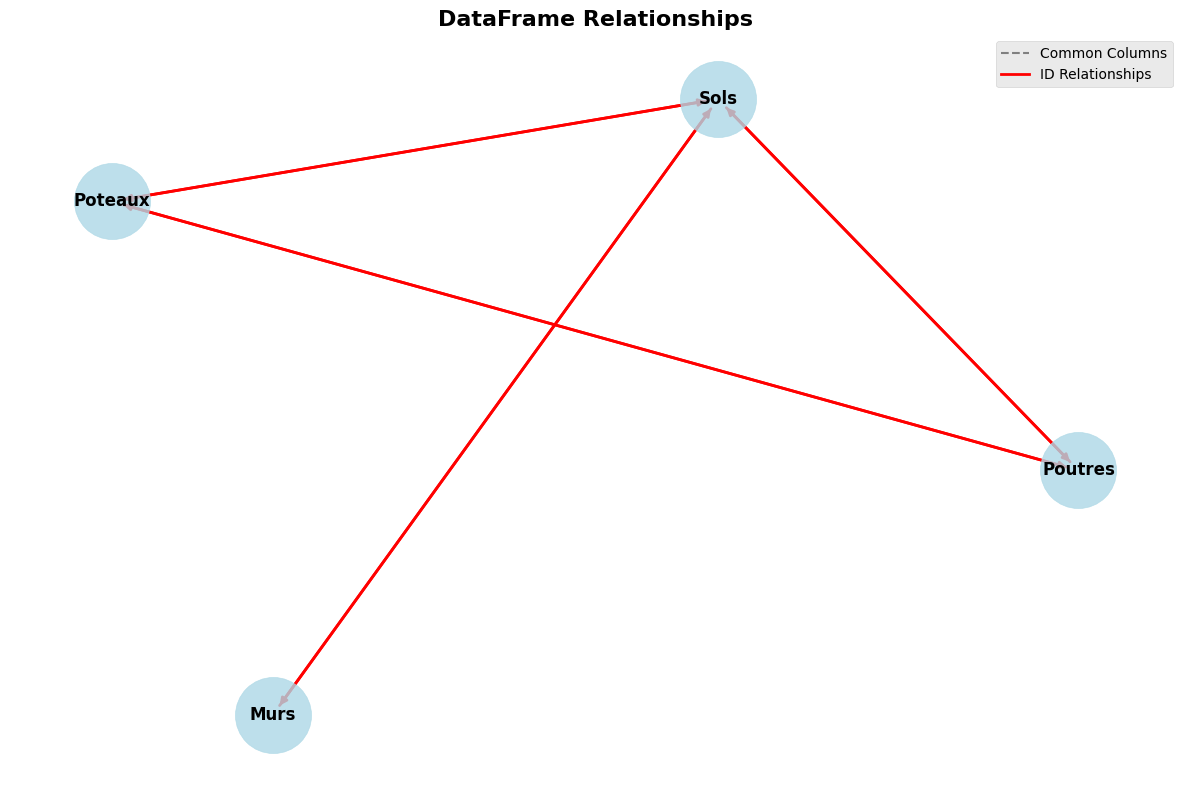

In [5]:
### ========================================
### Sanitization and Relationship Analysis
### ========================================
### Import the cleaner and mapper
from excel_essential_columns_cleaner import load_and_sanitize_data
from excel_map_sanitized_columns import analyze_relationships, display_column_mapping_results, generate_relationship_graph_matplotlib

# Load and fully sanitize the data
sanitized_data = load_and_sanitize_data(maquettes_path)

### Now ALL subsequent operations use the sanitized data
### --------------------------------------------------

### Analyze relationships
relationships = analyze_relationships(sanitized_data)

### Display results
display_column_mapping_results(relationships, sanitized_data)


### Now work exclusively with sanitized_data for all operations
murs_df = sanitized_data['Murs']
sols_df = sanitized_data['Sols']
poutres_df = sanitized_data['Poutres']
poteaux_df = sanitized_data['Poteaux']

### Generate graph
generate_relationship_graph_matplotlib(relationships)
### save the graph if not already saved
maquette_name = os.path.splitext(os.path.basename(maquettes_path))[0]  # Extract maquette name from file path
graph_path = os.path.join(plots_folder, f"{maquette_name}_relationship_graph.png")
if not os.path.exists(graph_path):
    plt.savefig(graph_path, bbox_inches='tight')
    print(f"Graph saved to {graph_path}")

In [6]:
import excel_clean_ids_columns

df_dict = {'Murs': murs_df, 'Sols': sols_df, 'Poutres': poutres_df, 'Poteaux': poteaux_df}

cleaned_dfs, renamed_columns = excel_clean_ids_columns.clean_ids_columns(df_dict)

🛁 Starting ID columns cleaning...

📋 Murs:

 🔄 Processing: Mur_Sols_coupés_u ↔ Mur_Sols_coupés_Ids


,Before_u,After_u,Before_ids,After_ids
0,0,0,nan,0
1,0,0,nan,0
2,0,0,nan,0


 ✨ Renamed to: Mur_Sols_coupés_Ids_cleaned
──────────────────────────────────────────────────

 🔄 Processing: Mur_Sols_coupants_u ↔ Mur_Sols_coupants_Ids


,Before_u,After_u,Before_ids,After_ids
0,3,3,"1788267,1788458,1790282","1788267,1788458,1790282"
1,1,1,1788267,1788267
2,1,1,1788267,1788267


 ✨ Renamed to: Mur_Sols_coupants_Ids_cleaned
──────────────────────────────────────────────────
📋 Sols:

 🔄 Processing: Sol_Murs_coupés_u ↔ Sol_Murs_coupés_Ids


,Before_u,After_u,Before_ids,After_ids
0,0,0,nan,0
1,9,9,"1787858,1787860,1787874,1789104,1789106,179026...","1787858,1787860,1787874,1789104,1789106,179026..."
2,3,3,"1788054,1789308,1794860","1788054,1789308,1794860"


 ✨ Renamed to: Sol_Murs_coupés_Ids_cleaned
──────────────────────────────────────────────────

 🔄 Processing: Sol_Murs_coupants_u ↔ Sol_Murs_coupants_Ids


,Before_u,After_u,Before_ids,After_ids
0,0,0,nan,0
1,0,0,nan,0
2,0,0,nan,0


 ✨ Renamed to: Sol_Murs_coupants_Ids_cleaned
──────────────────────────────────────────────────

 🔄 Processing: Sol_Poutres_coupés_u ↔ Sol_Poutres_coupés_Ids


,Before_u,After_u,Before_ids,After_ids
0,1,1,1793428,1793428
1,1,1,1788274,1788274
2,0,0,nan,0


 ✨ Renamed to: Sol_Poutres_coupés_Ids_cleaned
──────────────────────────────────────────────────

 🔄 Processing: Sol_Poutres_coupants_u ↔ Sol_Poutres_coupants_Ids


,Before_u,After_u,Before_ids,After_ids
0,0,0,nan,0
1,0,0,nan,0
2,0,0,nan,0


 ✨ Renamed to: Sol_Poutres_coupants_Ids_cleaned
──────────────────────────────────────────────────

 🔄 Processing: Sol_Poteaux_coupés_u ↔ Sol_Poteaux_coupés_Ids


,Before_u,After_u,Before_ids,After_ids
0,0,0,nan,0
1,0,0,nan,0
2,0,0,nan,0


 ✨ Renamed to: Sol_Poteaux_coupés_Ids_cleaned
──────────────────────────────────────────────────

 🔄 Processing: Sol_Poteaux_coupants_u ↔ Sol_Poteaux_coupants_Ids


,Before_u,After_u,Before_ids,After_ids
0,0,0,nan,0
1,0,0,nan,0
2,0,0,nan,0


 ✨ Renamed to: Sol_Poteaux_coupants_Ids_cleaned
──────────────────────────────────────────────────
📋 Poutres:

 🔄 Processing: Poutre_Sols_coupés_u ↔ Poutre_Sols_coupés_Ids


,Before_u,After_u,Before_ids,After_ids
0,0,0,nan,0
1,0,0,nan,0
2,0,0,nan,0


 ✨ Renamed to: Poutre_Sols_coupés_Ids_cleaned
──────────────────────────────────────────────────

 🔄 Processing: Poutre_Sols_coupants_u ↔ Poutre_Sols_coupants_Ids


,Before_u,After_u,Before_ids,After_ids
0,0,0,nan,0
1,0,0,nan,0
2,0,0,nan,0


 ✨ Renamed to: Poutre_Sols_coupants_Ids_cleaned
──────────────────────────────────────────────────

 🔄 Processing: Poutre_Poteaux_coupés_u ↔ Poutre_Poteaux_coupés_Ids


,Before_u,After_u,Before_ids,After_ids
0,0,0,nan,0
1,0,0,nan,0
2,0,0,nan,0


 ✨ Renamed to: Poutre_Poteaux_coupés_Ids_cleaned
──────────────────────────────────────────────────
 ⚠️ Poutre_Poteaux_coupants_u → No matching IDs column
📋 Poteaux:

 🔄 Processing: Poteau_Sols_coupés_u ↔ Poteau_Sols_coupés_Ids


,Before_u,After_u,Before_ids,After_ids
0,0,0,nan,0
1,0,0,nan,0
2,0,0,nan,0


 ✨ Renamed to: Poteau_Sols_coupés_Ids_cleaned
──────────────────────────────────────────────────

 🔄 Processing: Poteau_Sols_coupants_u ↔ Poteau_Sols_coupants_Ids


,Before_u,After_u,Before_ids,After_ids
0,1,1,1788810,1788810
1,0,0,nan,0
2,0,0,nan,0


 ✨ Renamed to: Poteau_Sols_coupants_Ids_cleaned
──────────────────────────────────────────────────

 🔄 Processing: Poteau_Poutres_coupés_u ↔ Poteau_Poutres_coupés_Ids


,Before_u,After_u,Before_ids,After_ids
0,2,2,"1788966,1795639","1788966,1795639"
1,1,1,1788934,1788934
2,1,1,1788936,1788936


 ✨ Renamed to: Poteau_Poutres_coupés_Ids_cleaned
──────────────────────────────────────────────────

 🔄 Processing: Poteau_Poutres_coupants_u ↔ Poteau_Poutres_coupants_Ids


,Before_u,After_u,Before_ids,After_ids
0,0,0,nan,0
1,0,0,nan,0
2,0,0,nan,0


 ✨ Renamed to: Poteau_Poutres_coupants_Ids_cleaned
──────────────────────────────────────────────────

✅ FINAL COLUMNS PER DATAFRAME:

📌 Murs columns:
 • Mur_Id 
 • Mur_011EC_Lot 
 • Mur_012EC_Ouvrage 
 • Mur_013EC_Localisation 
 • Mur_014EC_Mode_Constructif 
 • Mur_Hauteur 
 • Mur_Epaisseur 
 • Mur_AI 
 • Mur_AS 
 • Mur_Sols_en_intersection 
 • Mur_Sols_coupés_u 
 • Mur_Sols_coupés_Ids_cleaned (renamed)
 • Mur_Sols_coupants_u 
 • Mur_Sols_coupants_Ids_cleaned (renamed)
 • Mur_Sol_au-dessus 
 • Mur_Sol_en-dessous 
 • Mur_Fenêtres 
 • Mur_Portes 
 • Mur_Ouvertures 
 • Mur_Murs_imbriqués 
 • Mur_Mur_multicouche 
 • Mur_Profil_modifié 
 • Mur_Extension_inférieure 
 • Mur_Extension_supérieure 
 • Mur_Volume 
 • Mur_Surface 
 • Mur_Partie_inférieure_attachée 
 • Mur_Partie_supérieure_attachée 
 • Mur_Décalage_supérieur 
 • Mur_Décalage_inférieur 
 • Mur_Matériau_structurel 

📌 Sols columns:
 • Sol_Id 
 • Sol_011EC_Lot 
 • Sol_012EC_Ouvrage 
 • Sol_013EC_Localisation 
 • Sol_014EC_Mode_Const


🔍 Processing Murs...
✅ Found & Processed: Mur_Sols_coupés_Ids_cleaned, Added Count Column: Mur_Sols_coupés_Ids_cleaned_count
✅ Found & Processed: Mur_Sols_coupants_Ids_cleaned, Added Count Column: Mur_Sols_coupants_Ids_cleaned_count

🔍 Processing Sols...
✅ Found & Processed: Sol_Murs_coupés_Ids_cleaned, Added Count Column: Sol_Murs_coupés_Ids_cleaned_count
✅ Found & Processed: Sol_Murs_coupants_Ids_cleaned, Added Count Column: Sol_Murs_coupants_Ids_cleaned_count
✅ Found & Processed: Sol_Poutres_coupés_Ids_cleaned, Added Count Column: Sol_Poutres_coupés_Ids_cleaned_count
✅ Found & Processed: Sol_Poutres_coupants_Ids_cleaned, Added Count Column: Sol_Poutres_coupants_Ids_cleaned_count
✅ Found & Processed: Sol_Poteaux_coupés_Ids_cleaned, Added Count Column: Sol_Poteaux_coupés_Ids_cleaned_count
✅ Found & Processed: Sol_Poteaux_coupants_Ids_cleaned, Added Count Column: Sol_Poteaux_coupants_Ids_cleaned_count

🔍 Processing Poutres...
✅ Found & Processed: Poutre_Sols_coupés_Ids_cleaned, Added 

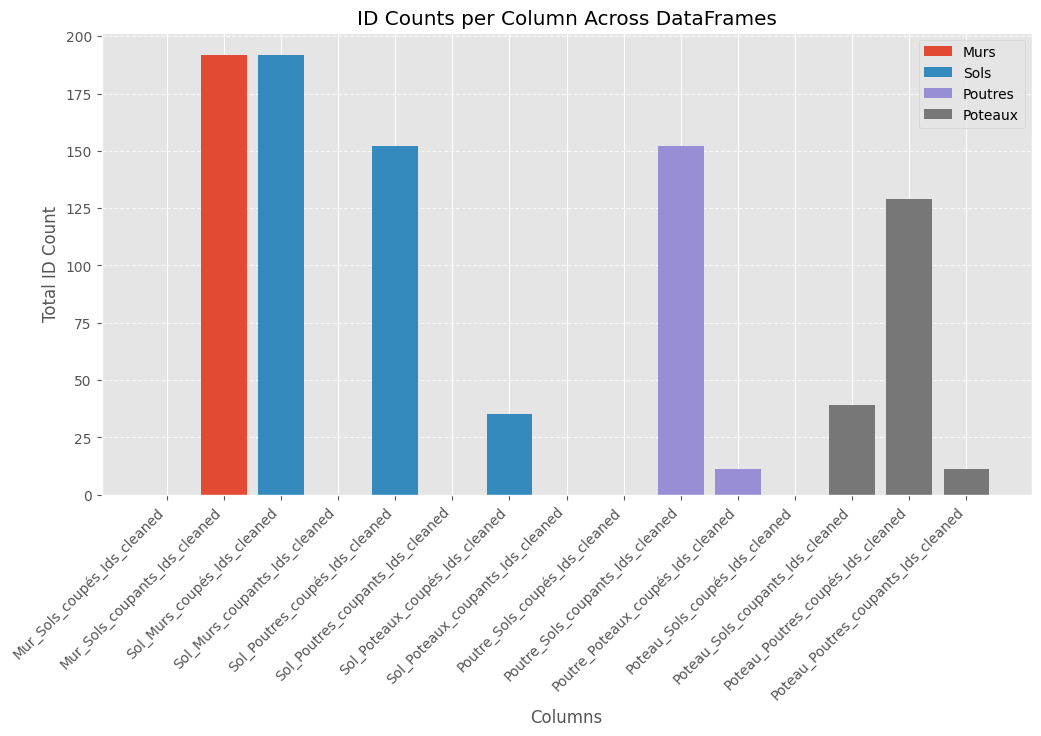

In [7]:
from excel_insertions_ids_counter import count_ids_per_row, plot_id_counts

df_dict, renamed_columns = count_ids_per_row(df_dict)
### ======================
### Show detected columns
### ======================
print("\n🆕 Processed Columns:")
for col_name in renamed_columns.keys():
    print(f"Detected & counted: {col_name}")

### ========================================
### Validate count columns in each DataFrame
### ========================================
for name, df in df_dict.items():
    df_count_cols = [col + "_count" for col in renamed_columns.keys() if (col + "_count") in df.columns]
    print(f"\n{name} DataFrame count columns:")
    if df_count_cols:
        print(df[df_count_cols].head())
    else:
        print("⚠️ No count columns found.")

### ========================================
### Generate plot based on processed data
### ========================================
plot_id_counts(df_dict, renamed_columns)
### save the graph if not already saved
graph_path = os.path.join(plots_folder, f"{maquette_name}_id_counts.png")
if not os.path.exists(graph_path):
    plt.savefig(graph_path, bbox_inches='tight')
    print(f"Graph saved to {graph_path}")


🔍 Processing relationships for Murs...
🔗 Linking Mur_Sols_coupés_Ids_cleaned in Murs → Sols
✅ Successfully linked 28 features from Sols
🔗 Linking Mur_Sols_coupants_Ids_cleaned in Murs → Sols
❌ Failed to process Mur_Sols_coupants_Ids_cleaned: cannot reindex on an axis with duplicate labels
🔗 Linking Mur_Sols_coupés_Ids_cleaned_count in Murs → Sols
✅ Successfully linked 28 features from Sols
🔗 Linking Mur_Sols_coupants_Ids_cleaned_count in Murs → Sols
✅ Successfully linked 28 features from Sols

🔍 Processing relationships for Sols...
🔗 Linking Sol_Murs_coupés_Ids_cleaned in Sols → Murs
❌ Failed to process Sol_Murs_coupés_Ids_cleaned: cannot reindex on an axis with duplicate labels
🔗 Linking Sol_Murs_coupants_Ids_cleaned in Sols → Murs
✅ Successfully linked 60 features from Murs
🔗 Linking Sol_Poutres_coupés_Ids_cleaned in Sols → Poutres
❌ Failed to process Sol_Poutres_coupés_Ids_cleaned: cannot reindex on an axis with duplicate labels
🔗 Linking Sol_Poutres_coupants_Ids_cleaned in Sols → 

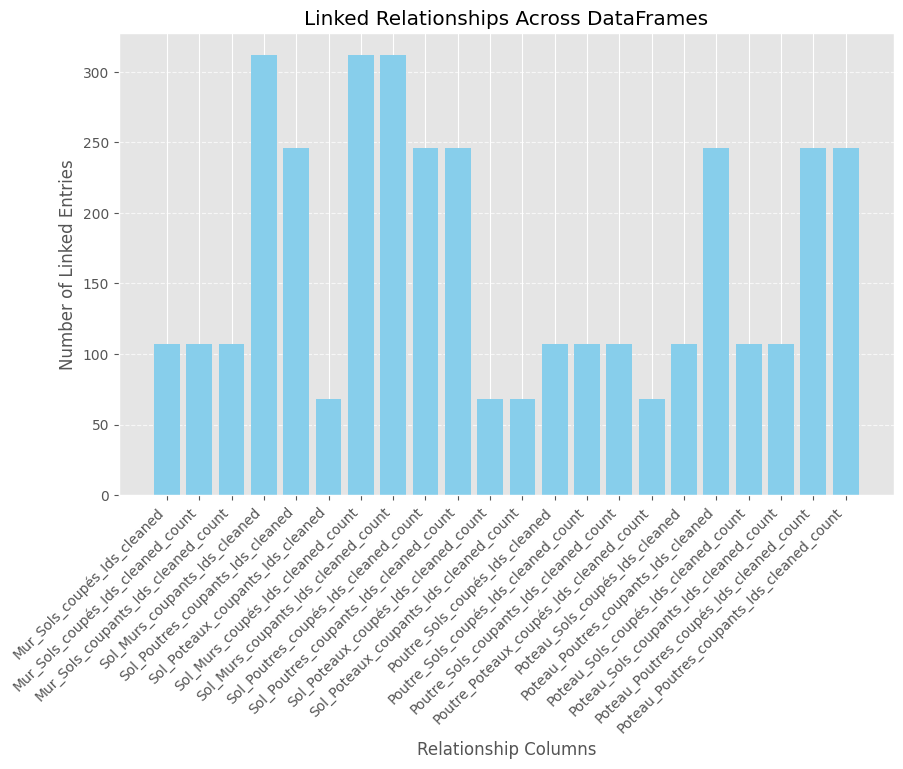

Interactive graph saved to ../../plot/RawData-Cibles/RawData-Cibles_linked_relationships.html


In [8]:
### ======================
### Link ID relationships
### ====================
from excel_link_id_relationships import link_id_relationships, plot_linked_relationships, plotly_network_graph
df_dict = {
    "Murs": murs_df,
    "Sols": sols_df,
    "Poutres": poutres_df,
    "Poteaux": poteaux_df
}
df_dict, linked_columns = link_id_relationships(df_dict)

### ====================================
### Visualize the linked relationships
### ====================================
plot_linked_relationships(df_dict, linked_columns)

### save the graph if not already saved
graph_path = os.path.join(plots_folder, f"{maquette_name}_linked_relationships.png")
if not os.path.exists(graph_path):
    plt.savefig(graph_path, bbox_inches='tight')
    print(f"Graph saved to {graph_path}")


### Generate relationship graph
graph_links = plotly_network_graph(df_dict, linked_columns)
html_path = os.path.join(plots_folder, f"{maquette_name}_linked_relationships.html")
graph_links.write_html(html_path)
print(f"Interactive graph saved to {html_path}")


In [9]:
# import plotly.graph_objects as go
# import networkx as nx

# def plotly_graphs(df_dict, column_mapping):
#     """
#     Creates two interactive network graphs:
#     - One for individual ID-based relationships (one node per connection).
#     - One for quantity-based coupés and coupants relationships.

#     Args:
#         df_dict (dict): Dictionary containing DataFrames.
#         column_mapping (dict): Mapping of sanitized column relationships.

#     Returns:
#         Tuple (fig_id_graph, fig_quantity_graph): Two Plotly figure objects.
#     """
#     G_ids = nx.Graph()  # Graph for ID-based relationships
#     G_quantities = nx.Graph()  # Graph for coupés and coupants relationships

#     # Build quantity-based graph for coupés/coupants relationships
#     for main_df_name, df in df_dict.items():
#         G_quantities.add_node(main_df_name, label=main_df_name, type='dataframe')

#         for column in df.columns:
#             if "_coupés_u" in column or "_coupants_u" in column:
#                 total_count = df[column].sum()
#                 if total_count > 0:  # Only add if there are actual relationships
#                     # Extract the target object type from column name
#                     parts = column.split('_')
#                     target_type = parts[1] if len(parts) > 1 else "Unknown"
#                     relation_type = "coupés" if "_coupés_u" in column else "coupants"

#                     edge_label = f"{main_df_name} {relation_type} {target_type}: {total_count}"
#                     G_quantities.add_edge(main_df_name, f"{target_type}s",
#                                         label=edge_label, weight=total_count)

#     # Build ID-based graph with individual connection nodes
#     for main_df_name, df in df_dict.items():
#         G_ids.add_node(main_df_name, label=main_df_name, type='dataframe')

#         for column in df.columns:
#             if "_coupés_Ids_cleaned" in column or "_coupants_Ids_cleaned" in column:
#                 # Extract target type and relation type
#                 parts = column.split('_')
#                 target_type = parts[1] if len(parts) > 1 else "Unknown"
#                 relation_type = "coupés" if "_coupés_Ids_cleaned" in column else "coupants"

#                 # Process each row to create individual connections
#                 for idx, row in df.iterrows():
#                     ids_value = row[column]
#                     if pd.notna(ids_value) and str(ids_value).strip():
#                         # Split IDs and create individual connection nodes
#                         ids_list = str(ids_value).split(',')
#                         for individual_id in ids_list:
#                             individual_id = individual_id.strip()
#                             if individual_id:
#                                 # Create unique connection node - handle column name mapping
#                                 if main_df_name == 'Poteaux':
#                                     id_column = 'Poteau_Id'
#                                 elif main_df_name == 'Poutres':
#                                     id_column = 'Poutre_Id'
#                                 elif main_df_name == 'Murs':
#                                     id_column = 'Mur_Id'
#                                 elif main_df_name == 'Sols':
#                                     id_column = 'Sol_Id'
#                                 else:
#                                     id_column = f'{main_df_name.rstrip("s")}_Id'
#                                 connection_node = f"{main_df_name}_{row[id_column]}_{relation_type}_{individual_id}"

#                                 G_ids.add_node(connection_node,
#                                              label=f"{relation_type}\n{individual_id}",
#                                              type='connection')

#                                 # Connect main dataframe to connection node
#                                 G_ids.add_edge(main_df_name, connection_node,
#                                              label=f"{main_df_name}→{individual_id}")

#                                 # Connect connection node to target dataframe
#                                 target_df = f"{target_type}s"
#                                 if target_df in df_dict:
#                                     G_ids.add_edge(connection_node, target_df,
#                                                  label=f"{individual_id}→{target_df}")

#     # Position nodes using different layouts
#     pos_ids = nx.spring_layout(G_ids, seed=42, k=3, iterations=50)
#     pos_quantities = nx.spring_layout(G_quantities, seed=42, k=2, iterations=50)

#     def create_graph_trace(G, pos, title_suffix=""):
#         """ Helper function to generate graph traces """
#         edge_x, edge_y, edge_text = [], [], []

#         for edge in G.edges():
#             x0, y0 = pos[edge[0]]
#             x1, y1 = pos[edge[1]]
#             edge_x += [x0, x1, None]
#             edge_y += [y0, y1, None]
#             # Get edge data safely
#             edge_data = G.edges[edge] if isinstance(G.edges[edge], dict) else {}
#             edge_text.append(edge_data.get('label', ''))

#         edge_trace = go.Scatter(x=edge_x, y=edge_y,
#                                line=dict(width=1.5, color='#888'),
#                                mode='lines', hoverinfo='none')

#         node_x, node_y, node_text, node_color, node_size = [], [], [], [], []
#         for node in G.nodes():
#             x, y = pos[node]
#             node_x.append(x)
#             node_y.append(y)
#             # Get node data safely
#             node_data = G.nodes[node] if isinstance(G.nodes[node], dict) else {}
#             node_type = node_data.get('type', 'default')

#             node_type = G.nodes[node]['type']
#             if node_type == 'dataframe':
#                 node_color.append('blue')
#                 node_size.append(25)
#             elif node_type == 'connection':
#                 node_color.append('red')
#                 node_size.append(15)
#             else:
#                 node_color.append('green')
#                 node_size.append(20)

#         node_trace = go.Scatter(
#             x=node_x, y=node_y,
#             mode='markers+text',
#             text=node_text,
#             textposition="top center",
#             hoverinfo='text',
#             marker=dict(showscale=False, color=node_color, size=node_size, line_width=2)
#         )
#         return edge_trace, node_trace

#     # Create ID-based graph
#     edge_trace_ids, node_trace_ids = create_graph_trace(G_ids, pos_ids)
#     fig_id_graph = go.Figure(data=[edge_trace_ids, node_trace_ids],
#                              layout=go.Layout(
#                                  title=dict(text='🔗 Individual ID Relationship Network', font=dict(size=16)),
#                                  showlegend=False,
#                                  hovermode='closest',
#                                  margin=dict(b=20, l=5, r=5, t=40),
#                                  xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
#                                  yaxis=dict(showgrid=False, zeroline=False, showticklabels=False)
#                              ))

#     # Create Quantity-based graph
#     edge_trace_quantities, node_trace_quantities = create_graph_trace(G_quantities, pos_quantities)
#     fig_quantity_graph = go.Figure(data=[edge_trace_quantities, node_trace_quantities],
#                                    layout=go.Layout(
#                                        title=dict(text='📊 Quantity Relationship Network (coupés & coupants)', font=dict(size=16)),
#                                        showlegend=False,
#                                        hovermode='closest',
#                                        margin=dict(b=20, l=5, r=5, t=40),
#                                        xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
#                                        yaxis=dict(showgrid=False, zeroline=False, showticklabels=False)
#                                    ))

#     return fig_id_graph, fig_quantity_graph


# fig_id_graph, fig_quantity_graph = plotly_graphs(sanitized_data, relationships)
# fig_id_graph.show()
# fig_quantity_graph.show()

In [10]:
###
### Show the network graph in a web browser
###
# import webbrowser
# webbrowser.open(os.path.join(plots_folder, "network_graph_quantities.html"))

# Feature Engineering & Target Preparation & Exploratory Data Analysis & Correlation Analysis

In [ ]:
def standardize_columns(df_dict):
    """Convert all column names to lowercase and standardize dataframe names."""
    try:
        standardized_dict = {}
        for df_name, df in df_dict.items():
            df.columns = df.columns.str.lower()
            standardized_dict[df_name.lower()] = df
        return standardized_dict
    except Exception as e:
        print(f"Error in standardize_columns: {str(e)}")
        raise

# Data Standardization
print("\n=== Standardizing Data ===")
processed_df_v3 = standardize_columns(processed_df_v3)

# Display standardized DataFrame names and columns
print("\nStandardized DataFrames:")
for df_name, df in processed_df_v3.items():
    print(f"\n{df_name} DataFrame:")
    print(df.columns.tolist())


=== Standardizing Data ===

Standardized DataFrames:

murs DataFrame:
['mur_id', 'mur_011ec_lot', 'mur_012ec_ouvrage', 'mur_013ec_localisation', 'mur_014ec_mode_constructif', 'mur_hauteur', 'mur_epaisseur', 'mur_ai', 'mur_as', 'mur_sols_en_intersection', 'mur_sols_coupés_u', 'mur_sols_coupants_u', 'mur_sols_coupants_ids_cleaned', 'mur_sol_au-dessus', 'mur_sol_en-dessous', 'mur_fenêtres', 'mur_portes', 'mur_ouvertures', 'mur_murs_imbriqués', 'mur_mur_multicouche', 'mur_profil_modifié', 'mur_extension_inférieure', 'mur_extension_supérieure', 'mur_volume', 'mur_surface', 'mur_partie_inférieure_attachée', 'mur_partie_supérieure_attachée', 'mur_décalage_supérieur', 'mur_décalage_inférieur', 'mur_matériau_structurel']

sols DataFrame:
['sol_id', 'sol_011ec_lot', 'sol_012ec_ouvrage', 'sol_013ec_localisation', 'sol_014ec_mode_constructif', 'sol_murs_en_intersection', 'sol_murs_coupés_u', 'sol_murs_coupés_ids_cleaned', 'sol_murs_coupants_u', 'sol_poutres_en_intersection', 'sol_poutres_coupés_u

In [24]:
def identify_targets(df_dict):
    """Identify target columns safely, avoiding missing column errors."""
    try:
        target_patterns = ['011ec_lot', '012ec_ouvrage', '013ec_localisation', '014ec_mode_constructif']

        targets, features = {}, {}

        for df_name, df in df_dict.items():
            df.columns = df.columns.str.lower()  # Standardize column names

            # Find matching target columns that actually exist
            target_cols = [col for col in df.columns if any(re.search(patt, col, re.IGNORECASE) for patt in target_patterns)]
            existing_targets = [col for col in target_cols if col in df.columns]  # Avoid KeyErrors

            feature_cols = [col for col in df.columns if col not in existing_targets]

            targets[df_name] = df[existing_targets]
            features[df_name] = df[feature_cols]

            print(f"Identified {len(existing_targets)} target columns in {df_name}: {existing_targets}")

        return targets, features
    except Exception as e:
        print(f"Error in identify_targets: {str(e)}")
        raise

# Identifying Targets
print("\n=== Identifying Targets ===")
targets, features = identify_targets(processed_df_v3)


=== Identifying Targets ===
Identified 4 target columns in murs: ['mur_011ec_lot', 'mur_012ec_ouvrage', 'mur_013ec_localisation', 'mur_014ec_mode_constructif']
Identified 4 target columns in sols: ['sol_011ec_lot', 'sol_012ec_ouvrage', 'sol_013ec_localisation', 'sol_014ec_mode_constructif']
Identified 4 target columns in poutres: ['poutre_011ec_lot', 'poutre_012ec_ouvrage', 'poutre_013ec_localisation', 'poutre_014ec_mode_constructif']
Identified 4 target columns in poteaux: ['poteau_011ec_lot', 'poteau_012ec_ouvrage', 'poteau_013ec_localisation', 'poteau_014ec_mode_constructif']


In [25]:
import pandas as pd
import re

def drop_specific_target_columns(df_dict):
    """
    Drops columns that match ['011ec_lot', '012ec_ouvrage', '013ec_localisation', '014ec_mode_constructif']
    while preserving prefixed versions (e.g., 'mur_011ec_lot', 'sol_012ec_ouvrage', etc.).

    Args:
        df_dict (dict): Dictionary of DataFrames.

    Returns:
        cleaned_dict (dict): Dictionary with target columns removed where applicable.
    """
    target_columns = ['011ec_lot', '012ec_ouvrage', '013ec_localisation', '014ec_mode_constructif']
    prefixes = ['mur_', 'sol_', 'poutre_', 'poteau_']

    cleaned_dict = {}

    for df_name, df in df_dict.items():
        # Identify columns to drop that do NOT start with allowed prefixes
        cols_to_drop = [col for col in df.columns if any(col == target for target in target_columns) and not any(col.startswith(pref) for pref in prefixes)]

        # Drop selected columns
        cleaned_df = df.drop(columns=cols_to_drop)
        cleaned_dict[df_name] = cleaned_df

        print(f"Dropped {len(cols_to_drop)} columns from {df_name}: {cols_to_drop}")

    return cleaned_dict

def drop_missing_columns(df_dict):
    """Drop columns with 100% missing values."""
    cleaned_dict = {}
    for df_name, df in df_dict.items():
        missing_percent = df.isna().mean()
        cols_to_drop = missing_percent[missing_percent == 1].index.tolist()
        cleaned_df = df.drop(columns=cols_to_drop)
        cleaned_dict[df_name] = cleaned_df
        print(f"Dropped {len(cols_to_drop)} 100% missing columns from {df_name}")
    return cleaned_dict

def drop_id_count_columns(df_dict):
    """Drop columns containing 'ids_cleaned_count' (case insensitive)."""
    cleaned_dict = {}
    for df_name, df in df_dict.items():
        count_cols = [col for col in df.columns if re.search(r'ids_cleaned_count', col, re.IGNORECASE)]
        cleaned_df = df.drop(columns=count_cols)
        cleaned_dict[df_name] = cleaned_df
        print(f"Dropped {len(count_cols)} ID count columns from {df_name}")
    return cleaned_dict

print("\n=== Cleaning Data ===")
processed_df_v3 = drop_missing_columns(processed_df_v3)
processed_df_v3 = drop_id_count_columns(processed_df_v3)
processed_df_v3 = drop_specific_target_columns(processed_df_v3)


=== Cleaning Data ===
Dropped 0 100% missing columns from murs
Dropped 0 100% missing columns from sols
Dropped 0 100% missing columns from poutres
Dropped 0 100% missing columns from poteaux
Dropped 0 ID count columns from murs
Dropped 0 ID count columns from sols
Dropped 0 ID count columns from poutres
Dropped 0 ID count columns from poteaux
Dropped 0 columns from murs: []
Dropped 0 columns from sols: []
Dropped 0 columns from poutres: []
Dropped 0 columns from poteaux: []


In [27]:
def identify_targets(df_dict):
    """Identify target columns safely, avoiding missing column errors, and store results in processed_df_v."""
    try:
        target_patterns = ['011ec_lot', '012ec_ouvrage', '013ec_localisation', '014ec_mode_constructif']

        targets, features = {}, {}
        processed_df_v = {}  # Dictionary to store processed DataFrames

        for df_name, df in df_dict.items():
            df.columns = df.columns.str.lower()  # Standardize column names

            # Find matching target columns that actually exist
            target_cols = [col for col in df.columns if any(re.search(patt, col, re.IGNORECASE) for patt in target_patterns)]
            existing_targets = [col for col in target_cols if col in df.columns]  # Avoid KeyErrors

            feature_cols = [col for col in df.columns if col not in existing_targets]

            targets[df_name] = df[existing_targets]
            features[df_name] = df[feature_cols]

            # Store processed DataFrame in processed_df_v
            processed_df_v[df_name] = df

            print(f"Identified {len(existing_targets)} target columns in {df_name}: {existing_targets}")

        return targets, features, processed_df_v
    except Exception as e:
        print(f"Error in identify_targets: {str(e)}")
        raise

# Identifying Targets
print("\n=== Identifying Targets ===")
targets, features = identify_targets(processed_df_v3)


=== Identifying Targets ===
Identified 4 target columns in murs: ['mur_011ec_lot', 'mur_012ec_ouvrage', 'mur_013ec_localisation', 'mur_014ec_mode_constructif']
Identified 4 target columns in sols: ['sol_011ec_lot', 'sol_012ec_ouvrage', 'sol_013ec_localisation', 'sol_014ec_mode_constructif']
Identified 4 target columns in poutres: ['poutre_011ec_lot', 'poutre_012ec_ouvrage', 'poutre_013ec_localisation', 'poutre_014ec_mode_constructif']
Identified 4 target columns in poteaux: ['poteau_011ec_lot', 'poteau_012ec_ouvrage', 'poteau_013ec_localisation', 'poteau_014ec_mode_constructif']


ValueError: too many values to unpack (expected 2)

In [31]:
print(f"📋 Available columns in {df_name} before correlation: {processed_df_v3[df_name].columns.tolist()}")
print(f"📊 Target Columns Expected in {df_name}: {targets[df_name].columns.tolist()}")


📋 Available columns in poteaux before correlation: ['poteau_id', 'poteau_011ec_lot', 'poteau_012ec_ouvrage', 'poteau_013ec_localisation', 'poteau_014ec_mode_constructif', 'poteau_nom', 'poteau_ai', 'poteau_as', 'poteau_hauteur', 'poteau_longueur', 'poteau_partie_inférieure_attachée', 'poteau_partie_supérieure_attachée', 'poteau_sols_en_intersection', 'poteau_sols_coupés_u', 'poteau_sols_coupants_u', 'poteau_sols_coupants_ids_cleaned', 'poteau_poutres_en_intersection', 'poteau_poutres_coupés_u', 'poteau_poutres_coupés_ids_cleaned', 'poteau_poutres_coupants_u', 'poteau_poutres_coupants_ids_cleaned', 'poteau_matériau_structurel', "poteau_marque_d'emplacement_du_poteau", 'poteau_décalage_supérieur', 'poteau_décalage_inférieur']
📊 Target Columns Expected in poteaux: ['poteau_011ec_lot', 'poteau_012ec_ouvrage', 'poteau_013ec_localisation', 'poteau_014ec_mode_constructif']


In [42]:
for df_name, df in processed_df_v3.items():
    print(f"📊 Numeric Columns in {df_name}: {df.select_dtypes(include=[np.number]).columns.tolist()}")

📊 Numeric Columns in murs: ['mur_id', 'mur_hauteur', 'mur_epaisseur', 'mur_ai', 'mur_as', 'mur_sols_en_intersection', 'mur_sols_coupés_u', 'mur_sols_coupants_u', 'mur_fenêtres', 'mur_portes', 'mur_ouvertures', 'mur_murs_imbriqués', 'mur_extension_inférieure', 'mur_extension_supérieure', 'mur_volume', 'mur_surface', 'mur_partie_inférieure_attachée', 'mur_partie_supérieure_attachée', 'mur_décalage_supérieur', 'mur_décalage_inférieur']
📊 Numeric Columns in sols: ['sol_id', 'sol_murs_en_intersection', 'sol_murs_coupés_u', 'sol_murs_coupants_u', 'sol_poutres_en_intersection', 'sol_poutres_coupés_u', 'sol_poutres_coupants_u', 'sol_poteaux_en_intersection', 'sol_poteaux_coupés_u', 'sol_poteaux_coupants_u', 'sol_volume', 'sol_surface']
📊 Numeric Columns in poutres: ['poutre_id', 'poutre_ai', 'poutre_as', 'poutre_hauteur_totale', 'poutre_hauteur', 'poutre_sols_en_intersection', 'poutre_sols_coupés_u', 'poutre_sols_coupants_u', 'poutre_poteaux_en_intersection', 'poutre_poteaux_coupés_u', 'poutre

In [43]:
for df_name, target_df in targets.items():
    print(f"🔍 Numeric Target Columns in {df_name}: {target_df.select_dtypes(include=[np.number]).columns.tolist()}")

🔍 Numeric Target Columns in murs: []
🔍 Numeric Target Columns in sols: []
🔍 Numeric Target Columns in poutres: []
🔍 Numeric Target Columns in poteaux: []


In [33]:
print(f"📋 Columns in poteaux before correlation: {processed_df_v3['poteaux'].columns.tolist()}")
print(f"📊 Target Columns Expected in poteaux: {targets['poteaux'].columns.tolist()}")

📋 Columns in poteaux before correlation: ['poteau_id', 'poteau_011ec_lot', 'poteau_012ec_ouvrage', 'poteau_013ec_localisation', 'poteau_014ec_mode_constructif', 'poteau_nom', 'poteau_ai', 'poteau_as', 'poteau_hauteur', 'poteau_longueur', 'poteau_partie_inférieure_attachée', 'poteau_partie_supérieure_attachée', 'poteau_sols_en_intersection', 'poteau_sols_coupés_u', 'poteau_sols_coupants_u', 'poteau_sols_coupants_ids_cleaned', 'poteau_poutres_en_intersection', 'poteau_poutres_coupés_u', 'poteau_poutres_coupés_ids_cleaned', 'poteau_poutres_coupants_u', 'poteau_poutres_coupants_ids_cleaned', 'poteau_matériau_structurel', "poteau_marque_d'emplacement_du_poteau", 'poteau_décalage_supérieur', 'poteau_décalage_inférieur']
📊 Target Columns Expected in poteaux: ['poteau_011ec_lot', 'poteau_012ec_ouvrage', 'poteau_013ec_localisation', 'poteau_014ec_mode_constructif']


In [51]:
for df_name, df in encoded_targets.items():
    print(f"🔍 Data types in {df_name}:\n{df.dtypes}")

🔍 Data types in murs:
mur_011ec_lot                 int64
mur_012ec_ouvrage             int64
mur_013ec_localisation        int64
mur_014ec_mode_constructif    int64
dtype: object
🔍 Data types in sols:
sol_011ec_lot                 int64
sol_012ec_ouvrage             int64
sol_013ec_localisation        int64
sol_014ec_mode_constructif    int64
dtype: object
🔍 Data types in poutres:
poutre_011ec_lot                 int64
poutre_012ec_ouvrage             int64
poutre_013ec_localisation        int64
poutre_014ec_mode_constructif    int64
dtype: object
🔍 Data types in poteaux:
poteau_011ec_lot                 int64
poteau_012ec_ouvrage             int64
poteau_013ec_localisation        int64
poteau_014ec_mode_constructif    int64
dtype: object


In [50]:
for df_name, df in processed_df_v3.items():
    print(f"🛑 NaN percentage in {df_name}: \n{df.isna().mean() * 100}")

🛑 NaN percentage in murs: 
mur_id                             0.000000
mur_011ec_lot                      0.000000
mur_012ec_ouvrage                  0.000000
mur_013ec_localisation             0.000000
mur_014ec_mode_constructif         0.000000
mur_hauteur                        0.000000
mur_epaisseur                      0.000000
mur_ai                             0.000000
mur_as                             0.000000
mur_sols_en_intersection           0.000000
mur_sols_coupés_u                  0.000000
mur_sols_coupants_u                0.000000
mur_sols_coupants_ids_cleaned     62.179487
mur_sol_au-dessus                  0.000000
mur_sol_en-dessous                 0.000000
mur_fenêtres                       0.000000
mur_portes                         0.000000
mur_ouvertures                     0.000000
mur_murs_imbriqués                 0.000000
mur_mur_multicouche                0.000000
mur_profil_modifié                 0.000000
mur_extension_inférieure           0.000000
mur_e

In [ ]:
from sklearn.preprocessing import LabelEncoder

def encode_all_target_dataframes(targets):
    """
    Encodes categorical columns using Label Encoding for all DataFrames in the targets dictionary.

    Args:
        targets (dict): Dictionary containing target DataFrames.

    Returns:
        encoded_targets (dict): Dictionary of encoded target DataFrames.
        label_encoders (dict): Dictionary of LabelEncoders used for transformation.
    """
    encoded_targets = {}
    label_encoders = {}

    for df_name, target_df in targets.items():
        encoders = {}

        # Apply Label Encoding on categorical columns
        for col in target_df.select_dtypes(include=['object']).columns:
            le = LabelEncoder()
            target_df[col] = le.fit_transform(target_df[col])  # Convert text to numeric codes
            encoders[col] = le  # Store encoder for later use

        encoded_targets[df_name] = target_df
        label_encoders[df_name] = encoders

        print(f"✅ Applied encoding to target columns in {df_name}: {target_df.columns.tolist()}")

    return encoded_targets, label_encoders

# Step 1: Encode categorical target variables
encoded_targets, label_encoders = encode_all_target_dataframes(targets)


✅ Applied encoding to target columns in murs: ['mur_011ec_lot', 'mur_012ec_ouvrage', 'mur_013ec_localisation', 'mur_014ec_mode_constructif']
✅ Applied encoding to target columns in sols: ['sol_011ec_lot', 'sol_012ec_ouvrage', 'sol_013ec_localisation', 'sol_014ec_mode_constructif']
✅ Applied encoding to target columns in poutres: ['poutre_011ec_lot', 'poutre_012ec_ouvrage', 'poutre_013ec_localisation', 'poutre_014ec_mode_constructif']
✅ Applied encoding to target columns in poteaux: ['poteau_011ec_lot', 'poteau_012ec_ouvrage', 'poteau_013ec_localisation', 'poteau_014ec_mode_constructif']


In [49]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def calculate_within_correlations(df, targets):
    """Safely calculate correlations within a single DataFrame."""
    try:
        # Ensure target columns exist in the DataFrame before correlation
        existing_targets = [col for col in targets.columns if col in df.columns]

        if not existing_targets:
            print(f"⚠️ Warning: No valid target columns found in DataFrame: {df.columns.tolist()}")
            return None

        # Perform correlation only on existing target columns
        correlation_matrix = df[existing_targets].corr()

        # Check if correlation matrix is valid
        if correlation_matrix.empty or correlation_matrix.isna().all().all():
            print(f"⚠️ No valid correlation data for {df.columns.tolist()}")
            return None

        return correlation_matrix.drop(existing_targets, errors='ignore')

    except Exception as e:
        print(f"Error in calculate_within_correlations: {str(e)}")
        raise


def analyze_all_correlations(df_dict, targets):
    """Orchestrate all correlation calculations with enhanced error handling."""
    try:
        all_correlations = {}

        for df_name, df in df_dict.items():
            print(f"\n🔍 Calculating correlations for {df_name}...")

            if df_name not in targets:
                print(f"⚠️ No target data found for {df_name}, skipping...")
                continue

            within_corr = calculate_within_correlations(df, targets[df_name])

            # Store correlations only if valid
            if within_corr is not None and not within_corr.empty:
                all_correlations[df_name] = {'within_dataframe': within_corr}

        return all_correlations

    except Exception as e:
        print(f"Error in analyze_all_correlations: {str(e)}")
        raise


def plot_correlation_heatmap(data, title):
    """Visualize a single correlation matrix safely with improved validation."""
    try:
        if data is None or data.empty or data.isna().all().all():
            print(f"⚠️ Skipping heatmap for {title}: No valid data")
            return

        plt.figure(figsize=(12, 8))
        sns.heatmap(data, annot=True, cmap='coolwarm', center=0)
        plt.title(title)
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"Error plotting heatmap: {str(e)}")


# Step 1: Perform correlation analysis using **encoded** targets
correlations = analyze_all_correlations(processed_df_v3, encoded_targets)

# Step 2: Visualize correlations if they exist
if correlations:
    for df_name, corr_data in correlations.items():
        if 'within_dataframe' in corr_data and corr_data['within_dataframe'] is not None:
            plot_correlation_heatmap(corr_data['within_dataframe'], f"Correlation Matrix for {df_name}")


🔍 Calculating correlations for murs...
⚠️ No valid correlation data for ['mur_id', 'mur_011ec_lot', 'mur_012ec_ouvrage', 'mur_013ec_localisation', 'mur_014ec_mode_constructif', 'mur_hauteur', 'mur_epaisseur', 'mur_ai', 'mur_as', 'mur_sols_en_intersection', 'mur_sols_coupés_u', 'mur_sols_coupants_u', 'mur_sols_coupants_ids_cleaned', 'mur_sol_au-dessus', 'mur_sol_en-dessous', 'mur_fenêtres', 'mur_portes', 'mur_ouvertures', 'mur_murs_imbriqués', 'mur_mur_multicouche', 'mur_profil_modifié', 'mur_extension_inférieure', 'mur_extension_supérieure', 'mur_volume', 'mur_surface', 'mur_partie_inférieure_attachée', 'mur_partie_supérieure_attachée', 'mur_décalage_supérieur', 'mur_décalage_inférieur', 'mur_matériau_structurel']

🔍 Calculating correlations for sols...
⚠️ No valid correlation data for ['sol_id', 'sol_011ec_lot', 'sol_012ec_ouvrage', 'sol_013ec_localisation', 'sol_014ec_mode_constructif', 'sol_murs_en_intersection', 'sol_murs_coupés_u', 'sol_murs_coupés_ids_cleaned', 'sol_murs_coupant

In [ ]:
def calculate_feature_importance(X, y, target_name):
    """Calculate feature importance for one target."""
    try:
        valid_idx = y.notna()
        X_valid, y_valid = X.loc[valid_idx], y.loc[valid_idx]
        model = RandomForestRegressor(n_estimators=100, random_state=42)
        model.fit(X_valid, y_valid)
        return pd.DataFrame({'feature': X.columns, 'importance': model.feature_importances_}).sort_values('importance', ascending=False)
    except Exception as e:
        print(f"Error calculating importance for {target_name}: {str(e)}")
        return None

def analyze_all_feature_importance(features, targets):
    """Calculate feature importance for all targets."""
    try:
        importance_results = {}
        for df_name, X in features.items():
            for target_col in targets[df_name].columns:
                print(f"\nAnalyzing importance for {target_col} in {df_name}")
                importance = calculate_feature_importance(X, targets[df_name][target_col], target_col)
                if importance is not None:
                    importance_results[f"{df_name}_{target_col}"] = importance
                    plt.figure(figsize=(10, 6))
                    sns.barplot(x='importance', y='feature', data=importance.head(20))
                    plt.title(f'Top Features for {target_col} in {df_name}')
                    plt.tight_layout()
                    plt.show()
        return importance_results
    except Exception as e:
        print(f"Error in analyze_all_feature_importance: {str(e)}")
        raise

# Feature Importance
print("\n=== Calculating Feature Importance ===")
importance_results = analyze_all_feature_importance(features, targets)


Starting analysis...

=== Standardizing data ===

=== Identifying targets ===
Identified 8 target columns in murs
Identified 20 target columns in sols
Identified 28 target columns in poutres
Identified 52 target columns in poteaux

=== Running correlation analysis ===

Calculating correlations for murs...
Calculating within-dataframe correlations...
Error in calculate_within_correlations: "['mur_011ec_lot', 'mur_012ec_ouvrage', 'mur_013ec_localisation', 'mur_014ec_mode_constructif'] not in index"
Error in analyze_all_correlations: "['mur_011ec_lot', 'mur_012ec_ouvrage', 'mur_013ec_localisation', 'mur_014ec_mode_constructif'] not in index"

Analysis failed: "['mur_011ec_lot', 'mur_012ec_ouvrage', 'mur_013ec_localisation', 'mur_014ec_mode_constructif'] not in index"


In [ ]:
for df_name, df in df_dict.items():
    print(f"📋 Columns in {df_name}: {df.columns.tolist()}")


📋 Columns in Murs: ['mur_id', 'mur_011ec_lot', 'mur_012ec_ouvrage', 'mur_013ec_localisation', 'mur_014ec_mode_constructif', 'mur_hauteur', 'mur_epaisseur', 'mur_ai', 'mur_as', 'mur_sols_en_intersection', 'mur_sols_coupés_u', 'mur_sols_coupés_ids_cleaned', 'mur_sols_coupants_u', 'mur_sols_coupants_ids_cleaned', 'mur_sol_au-dessus', 'mur_sol_en-dessous', 'mur_fenêtres', 'mur_portes', 'mur_ouvertures', 'mur_murs_imbriqués', 'mur_mur_multicouche', 'mur_profil_modifié', 'mur_extension_inférieure', 'mur_extension_supérieure', 'mur_volume', 'mur_surface', 'mur_partie_inférieure_attachée', 'mur_partie_supérieure_attachée', 'mur_décalage_supérieur', 'mur_décalage_inférieur', 'mur_matériau_structurel', 'mur_sols_coupés_ids_cleaned_count', 'mur_sols_coupants_ids_cleaned_count', 'sols_sol_011ec_lot_linked', 'sols_sol_012ec_ouvrage_linked', 'sols_sol_013ec_localisation_linked', 'sols_sol_014ec_mode_constructif_linked', 'sols_sol_murs_en_intersection_linked', 'sols_sol_murs_coupés_u_linked', 'sols_s

In [16]:
# Example: Test just the standardization
test_dict = standardize_columns({"Murs": murs_df.copy()})

# Example: Test just correlation calculation
test_corr = calculate_within_correlations(test_dict["murs"], targets["murs"])

Error in calculate_within_correlations: "None of [Index(['mur_011ec_lot', 'mur_012ec_ouvrage', 'mur_013ec_localisation',\n       'mur_014ec_mode_constructif'],\n      dtype='object')] are in the [columns]"


KeyError: "None of [Index(['mur_011ec_lot', 'mur_012ec_ouvrage', 'mur_013ec_localisation',\n       'mur_014ec_mode_constructif'],\n      dtype='object')] are in the [columns]"

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance

def prepare_data(df_dict):
    """
    Prepares data by:
    1. Dropping columns with 100% missing values
    2. Dropping columns containing "ids_cleaned_count"
    3. Identifying target columns
    """
    # Define target patterns
    target_patterns = ['011ec_lot', '012ec_ouvrage',
                      '013ec_localisation', '014ec_mode_constructif']

    processed_dfs = {}
    targets = {}
    features = {}

    for df_name, df in df_dict.items():
        # Convert to lowercase for consistency
        df.columns = df.columns.str()

        # 1. Drop 100% missing columns
        missing_percent = df.isna().mean()
        cols_to_drop = missing_percent[missing_percent == 1].index.tolist()
        df = df.drop(columns=cols_to_drop)

        # 2. Drop columns with "ids_cleaned_count"
        count_cols = [col for col in df.columns if "ids_cleaned_count" in col]
        df = df.drop(columns=count_cols)

        # Identify targets and features
        target_cols = [col for col in df.columns if any(patt in col for patt in target_patterns)]
        feature_cols = [col for col in df.columns if col not in target_cols]

        # Store results
        processed_dfs[df_name] = df
        targets[df_name] = df[target_cols]
        features[df_name] = df[feature_cols]

        print(f"Processed {df_name}:")
        print(f"- Dropped {len(cols_to_drop)} 100% missing columns")
        print(f"- Dropped {len(count_cols)} ID count columns")
        print(f"- Found {len(target_cols)} target columns and {len(feature_cols)} feature columns\n")

    return processed_dfs, targets, features

def analyze_correlations(processed_dfs, targets):
    """Analyze correlations between targets and features within and across dataframes"""
    all_correlations = {}

    for df_name, df in processed_dfs.items():
        # Get targets for this dataframe
        df_targets = targets[df_name]

        # Within-dataframe correlations
        within_corr = df.corr()[df_targets.columns].drop(df_targets.columns)

        # Cross-dataframe correlations
        cross_corrs = {}
        for other_df_name, other_df in processed_dfs.items():
            if other_df_name != df_name:
                # Find common index to align data
                common_index = df.index.intersection(other_df.index)
                if len(common_index) > 0:
                    combined = pd.concat([df.loc[common_index], other_df.loc[common_index]], axis=1)
                    cross_corr = combined.corr()[df_targets.columns].drop(combined.columns.intersection(df.columns))
                    cross_corrs[other_df_name] = cross_corr

        all_correlations[df_name] = {
            'within_dataframe': within_corr,
            'cross_dataframe': cross_corrs
        }

    return all_correlations

def plot_correlations(correlations):
    """Visualize correlation matrices"""
    for df_name, corr_data in correlations.items():
        # Plot within-dataframe correlations
        plt.figure(figsize=(12, 8))
        sns.heatmap(corr_data['within_dataframe'], annot=True, cmap='coolwarm', center=0)
        plt.title(f'Correlation with targets in {df_name} (within dataframe)')
        plt.show()

        # Plot cross-dataframe correlations
        for other_df, cross_corr in corr_data['cross_dataframe'].items():
            plt.figure(figsize=(12, 8))
            sns.heatmap(cross_corr, annot=True, cmap='coolwarm', center=0)
            plt.title(f'Correlation between {df_name} targets and {other_df} features')
            plt.show()

def feature_importance_analysis(features, targets):
    """Calculate feature importance using Random Forest"""
    importance_results = {}

    for df_name, X in features.items():
        y = targets[df_name]

        # For each target in the dataframe
        for target_col in y.columns:
            print(f"\nAnalyzing importance for {target_col} in {df_name}")

            # Prepare data (drop NA for this target)
            valid_idx = y[target_col].notna()
            X_valid = X.loc[valid_idx]
            y_valid = y.loc[valid_idx, target_col]

            # Train model
            model = RandomForestRegressor(n_estimators=100, random_state=42)
            model.fit(X_valid, y_valid)

            # Get feature importance
            importance = pd.DataFrame({
                'feature': X.columns,
                'importance': model.feature_importances_
            }).sort_values('importance', ascending=False)

            # Store results
            importance_results[f"{df_name}_{target_col}"] = importance

            # Plot top features
            plt.figure(figsize=(10, 6))
            sns.barplot(x='importance', y='feature',
                        data=importance.head(20))
            plt.title(f'Top Features for {target_col} in {df_name}')
            plt.show()

    return importance_results

# Main execution
if __name__ == "__main__":
    # Assuming df_dict contains your original dataframes
    df_dict = {
        "Murs": murs_df,
        "Sols": sols_df,
        "Poutres": poutres_df,
        "Poteaux": poteaux_df
    }

    # 1. Prepare data
    processed_dfs, targets, features = prepare_data(df_dict)

    # 2. Correlation analysis
    correlations = analyze_correlations(processed_dfs, targets)
    plot_correlations(correlations)

    # 3. Feature importance analysis
    importance_results = feature_importance_analysis(features, targets)Z

TypeError: 'StringMethods' object is not callable

In [12]:
from excel_merge_dfs import merge_all_dataframes, get_merged_dataframe

# merged_df = merge_all_dataframes(df_dict, maquette_name, processed_data_path)
# merged_df = get_merged_dataframe(maquette_name)

maquette_name = os.path.splitext(os.path.basename(maquettes_path))[0]
merged_df, merged_name, file_path = merge_all_dataframes(df_dict, maquette_name, processed_data_path)


# print(f"\n📏 Merged DataFrame '{maquette_name}_merged_v1' shape: {merged_df.shape}")
# print(f"🔍 Columns in '{maquette_name}_merged_v1': {merged_df.columns.tolist()}")


✅ Merged DataFrame 'RawData-Cibles_merged_v1' saved to: ../../data/processed/RawData-Cibles/RawData-Cibles_merged_v1.xlsx


In [13]:
# Verify missing values in the DataFrames
from excel_verifiy_missing_values import verify_missing_values_merged, missing_values_table, missing_values_table

print(f"\n🔍 {maquette_name} Missing Values Summary :")
missing_summary_table = missing_values_table(maquette_name)


🔍 RawData-Cibles Missing Values Summary :


,Column Name,Total Rows,Missing Values,Percentage Missing
0,mur_id,10000,0,0.0
1,mur_011ec_lot,10000,0,0.0
2,mur_012ec_ouvrage,10000,0,0.0
3,mur_013ec_localisation,10000,0,0.0
4,mur_014ec_mode_constructif,10000,0,0.0
...,...,...,...,...
540,poutres_poteaux_poteau_décalage_inférieur_link...,10000,10000,100.0
541,poutres_poteaux_poteau_sols_coupés_ids_cleaned...,10000,10000,100.0
542,poutres_poteaux_poteau_sols_coupants_ids_clean...,10000,10000,100.0
543,poutres_poteaux_poteau_poutres_coupés_ids_clea...,10000,10000,100.0



🔍 ANALYZING: RawData-Cibles_merged_v1
📏 Original shape of RawData-Cibles_merged_v1: (10000, 545)
📏 New shape of RawData-Cibles_merged_v1 after cleanup: (10000, 108)

📊 Missing Value Summary for RawData-Cibles_merged_v1:


,Column,Missing Count,Missing %
mur_id,mur_id,0,0.00%
mur_011ec_lot,mur_011ec_lot,0,0.00%
mur_012ec_ouvrage,mur_012ec_ouvrage,0,0.00%
mur_013ec_localisation,mur_013ec_localisation,0,0.00%
mur_014ec_mode_constructif,mur_014ec_mode_constructif,0,0.00%
mur_hauteur,mur_hauteur,0,0.00%
mur_epaisseur,mur_epaisseur,0,0.00%
mur_ai,mur_ai,0,0.00%
mur_as,mur_as,0,0.00%
mur_sols_en_intersection,mur_sols_en_intersection,0,0.00%


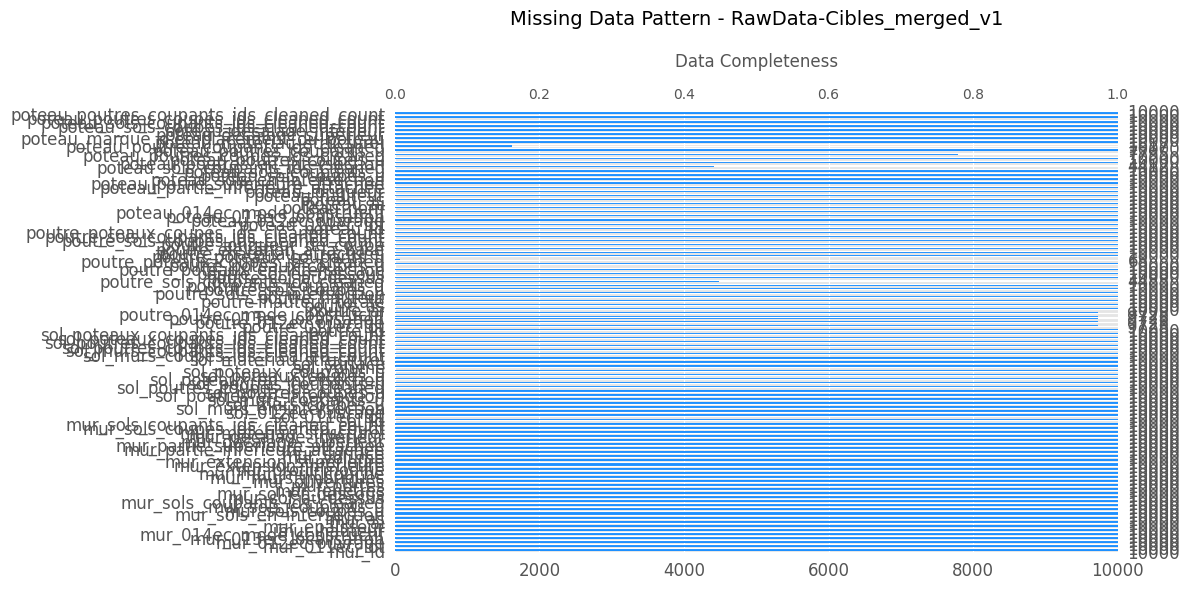


📋 SUMMARY OF DROPPED COLUMNS (100% missing)
 - mur_sols_coupés_ids_cleaned
 - sols_sol_011ec_lot_linked
 - sols_sol_012ec_ouvrage_linked
 - sols_sol_013ec_localisation_linked
 - sols_sol_014ec_mode_constructif_linked
 - sols_sol_murs_en_intersection_linked
 - sols_sol_murs_coupés_u_linked
 - sols_sol_murs_coupés_ids_cleaned_linked
 - sols_sol_murs_coupants_u_linked
 - sols_sol_murs_coupants_ids_cleaned_linked
 - sols_sol_poutres_en_intersection_linked
 - sols_sol_poutres_coupés_u_linked
 - sols_sol_poutres_coupés_ids_cleaned_linked
 - sols_sol_poutres_coupants_u_linked
 - sols_sol_poutres_coupants_ids_cleaned_linked
 - sols_sol_poteaux_en_intersection_linked
 - sols_sol_poteaux_coupés_u_linked
 - sols_sol_poteaux_coupés_ids_cleaned_linked
 - sols_sol_poteaux_coupants_u_linked
 - sols_sol_poteaux_coupants_ids_cleaned_linked
 - sols_sol_volume_linked
 - sols_sol_surface_linked
 - sols_sol_matériau_structurel_linked
 - sols_sol_murs_coupés_ids_cleaned_count_linked
 - sols_sol_murs_coupan

In [ ]:
###
### Drop columns with 100% missing values
###

from excel_drop_zero_values import drop_zero_values_columns_merged

cleaned_df_v1, missing_summary_v1, dropped_cols_v1 = drop_zero_values_columns_merged(maquette_name)

# Print summary of dropped columns
print("\n" + "="*50)
print("📋 SUMMARY OF DROPPED COLUMNS (100% missing)")
print("="*50)
for col in dropped_cols_v1:
    if col:  # Only show if columns were dropped
        print(f" - {col}")


In [ ]:
from excel_dropping_ids_count_columns import find_columns_with_keyword, drop_columns_with_keyword, export_cleaned_dataframe

matching_columns = find_columns_with_keyword(cleaned_df_v1)
cleaned_df_v2 = drop_columns_with_keyword(cleaned_df_v1)
export_cleaned_dataframe(cleaned_df_v2, maquette_name, processed_data_path)



🔍 Columns containing '_ids_cleaned_count':
 - mur_sols_coupés_ids_cleaned_count
 - mur_sols_coupants_ids_cleaned_count
 - sol_murs_coupés_ids_cleaned_count
 - sol_murs_coupants_ids_cleaned_count
 - sol_poutres_coupés_ids_cleaned_count
 - sol_poutres_coupants_ids_cleaned_count
 - sol_poteaux_coupés_ids_cleaned_count
 - sol_poteaux_coupants_ids_cleaned_count
 - poutre_sols_coupés_ids_cleaned_count
 - poutre_sols_coupants_ids_cleaned_count
 - poutre_poteaux_coupés_ids_cleaned_count
 - poteau_sols_coupés_ids_cleaned_count
 - poteau_sols_coupants_ids_cleaned_count
 - poteau_poutres_coupés_ids_cleaned_count
 - poteau_poutres_coupants_ids_cleaned_count

📏 Original shape: (10000, 108)

❌ Dropping columns containing '_ids_cleaned_count':
 - mur_sols_coupés_ids_cleaned_count
 - mur_sols_coupants_ids_cleaned_count
 - sol_murs_coupés_ids_cleaned_count
 - sol_murs_coupants_ids_cleaned_count
 - sol_poutres_coupés_ids_cleaned_count
 - sol_poutres_coupants_ids_cleaned_count
 - sol_poteaux_coupés_ids_

'../../data/processed/RawData-Cibles/RawData-Cibles_merged_v2.xlsx'

In [ ]:
def find_columns_with_keyword(df, keyword="_ids_cleaned"):
    """
    Finds and displays columns that contain a specific keyword in their names.

    Args:
        df (pd.DataFrame): The DataFrame to scan.
        keyword (str): The keyword to search for in column names.

    Returns:
        List of matching column names.
    """
    matching_columns = [col for col in df.columns if keyword in col]

    if matching_columns:
        print(f"\n🔍 Columns containing '{keyword}':")
        for col in matching_columns:
            print(f" - {col}")
    else:
        print(f"\n✅ No columns found with '{keyword}' in their names.")

    return matching_columns


def check_missing_values_in_cleaned_ids(df, keyword="_ids_cleaned"):
    """
    Identifies columns containing a specific keyword and checks for missing values.

    Args:
        df (pd.DataFrame): The DataFrame to scan.
        keyword (str): The keyword to search for in column names.

    Returns:
        missing_values_df (pd.DataFrame): Summary of missing values in matching columns.
    """
    # Find columns matching the keyword
    matching_columns = [col for col in df.columns if keyword in col]

    if matching_columns:
        print(f"\n🔍 Checking for missing values in columns containing '{keyword}':")

        # Create summary table for missing values
        missing_values_df = pd.DataFrame({
            "Column Name": matching_columns,
            "Total Rows": [df.shape[0]] * len(matching_columns),
            "Missing Values": [df[col].isna().sum() for col in matching_columns],
            "Percentage Missing": [df[col].isna().mean() * 100 for col in matching_columns]
        })

        # Display summary
        display(missing_values_df.style.format({"Percentage Missing": "{:.2f}%"}))

        return missing_values_df
    else:
        print(f"\n✅ No columns found with '{keyword}' in their names.")
        return None

matching_columns = find_columns_with_keyword(cleaned_df_v2)
missing_summary = check_missing_values_in_cleaned_ids(cleaned_df_v2)



🔍 Columns containing '_ids_cleaned':
 - mur_sols_coupants_ids_cleaned
 - sol_poutres_coupés_ids_cleaned
 - poutre_sols_coupants_ids_cleaned
 - poutre_poteaux_coupés_ids_cleaned
 - poteau_sols_coupants_ids_cleaned
 - poteau_poutres_coupés_ids_cleaned
 - poteau_poutres_coupants_ids_cleaned

🔍 Checking for missing values in columns containing '_ids_cleaned':


,Column Name,Total Rows,Missing Values,Percentage Missing
0,mur_sols_coupants_ids_cleaned,10000,0,0.00%
1,sol_poutres_coupés_ids_cleaned,10000,0,0.00%
2,poutre_sols_coupants_ids_cleaned,10000,5512,55.12%
3,poutre_poteaux_coupés_ids_cleaned,10000,9932,99.32%
4,poteau_sols_coupants_ids_cleaned,10000,5588,55.88%
5,poteau_poutres_coupés_ids_cleaned,10000,2205,22.05%
6,poteau_poutres_coupants_ids_cleaned,10000,8383,83.83%


In [ ]:
import pandas as pd

def check_duplicate_values(df):
    """
    Identifies duplicate values in the DataFrame and provides a summary of duplicate occurrences.

    Args:
        df (pd.DataFrame): The DataFrame to scan.

    Returns:
        duplicates_summary (pd.DataFrame): Summary of duplicate values in the DataFrame.
    """
    # Count total duplicate rows
    total_duplicates = df.duplicated().sum()

    print(f"\n🔍 Total Duplicate Rows: {total_duplicates}")

    if total_duplicates > 0:
        # Identify duplicate rows
        duplicate_rows = df[df.duplicated()]

        # Display the duplicate rows
        print("\n🔍 Sample of Duplicate Rows:")
        display(duplicate_rows.head())

        # Count duplicates per column
        duplicates_summary = df.apply(lambda col: col.duplicated().sum()).reset_index()
        duplicates_summary.columns = ["Column Name", "Duplicate Count"]

        # Filter columns with duplicates
        duplicates_summary = duplicates_summary[duplicates_summary["Duplicate Count"] > 0]

        # Display summary
        print("\n📊 Summary of Duplicate Values Per Column:")
        display(duplicates_summary)

        return duplicates_summary
    else:
        print("\n✅ No duplicate rows found in the DataFrame.")
        return None

duplicates_summary = check_duplicate_values(cleaned_df_v2)



🔍 Total Duplicate Rows: 0

✅ No duplicate rows found in the DataFrame.


In [ ]:
# Extract numerical columns for correlation mapping
corr_matrix = murs_df.select_dtypes(include=['number']).corr()

# Plot correlation heatmap
plt.figure(figsize=(21, 21))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Feature Correlation Matrix")
plt.show()

In [ ]:
# Feature selection for Murs DataFrame
# We'll exclude the target columns and ID columns from features
excluded_features = target_columns + ['Id', 'Sols coupés (Ids)', 'Sols coupants (Ids)']
features = [col for col in mur_df.columns if col not in excluded_features]

# Separate features and targets
X = mur_df[features]
y = mur_df[target_columns]

# Handle categorical features (text with special French characters)
categorical_cols = X.select_dtypes(include=['object']).columns
numeric_cols = X.select_dtypes(include=np.number).columns

print("Categorical columns:", categorical_cols)
print("Numeric columns:", numeric_cols)

# Preprocessing pipeline
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# Numeric transformer
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Categorical transformer
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine transformers
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Apply preprocessing
X_processed = preprocessor.fit_transform(X)

# For multi-label classification, we'll use separate models for each target
# Or we can combine them into a single target (less recommended due to different natures)
# Here we'll proceed with separate models

# Get feature names after one-hot encoding
# For numeric features
numeric_feature_names = numeric_cols.tolist()

# For categorical features
if len(categorical_cols) > 0:
    ohe = preprocessor.named_transformers_['cat'].named_steps['onehot']
    categorical_feature_names = ohe.get_feature_names_out(categorical_cols).tolist()
    all_feature_names = numeric_feature_names + categorical_feature_names
else:
    all_feature_names = numeric_feature_names

print(f"Total features after preprocessing: {len(all_feature_names)}")

In [ ]:
# Correlation analysis for each target variable
plt.figure(figsize=(15, 10))

# For numeric features only (correlation requires numeric data)
numeric_df = X[numeric_cols]

# Add targets to the numeric_df for correlation
for target in target_columns:
    if target in mur_df.columns:
        # Encode target for correlation
        le = LabelEncoder()
        encoded_target = le.fit_transform(mur_df[target])
        numeric_df[target] = encoded_target

# Compute correlation matrix
corr_matrix = numeric_df.corr()

# Plot heatmap for each target
for i, target in enumerate(target_columns, 1):
    if target in numeric_df.columns:
        plt.subplot(2, 2, i)
        target_corr = corr_matrix[target].sort_values(ascending=False)
        sns.barplot(x=target_corr.values[1:11], y=target_corr.index[1:11])
        plt.title(f'Top 10 Features Correlated with {target}')
        plt.tight_layout()

plt.show()

# Analyze distribution of target variables
plt.figure(figsize=(15, 10))
for i, target in enumerate(target_columns, 1):
    if target in mur_df.columns:
        plt.subplot(2, 2, i)
        sns.countplot(y=mur_df[target], order=mur_df[target].value_counts().index)
        plt.title(f'Distribution of {target}')
        plt.tight_layout()

plt.show()

# SHAP analysis for feature importance (sample for one target)
if '012EC_Ouvrage' in mur_df.columns:
    # Sample a subset for faster SHAP computation
    X_sample = X_processed[:1000] if X_processed.shape[0] > 1000 else X_processed

    # Train a model for this target
    y_target = mur_df['012EC_Ouvrage']
    le = LabelEncoder()
    y_encoded = le.fit_transform(y_target)

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X_sample, y_encoded, test_size=0.2, random_state=42)

    # Train a model
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)

    # Compute SHAP values
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_test)

    # Plot summary
    plt.figure()
    shap.summary_plot(shap_values, X_test, feature_names=all_feature_names, class_names=le.classes_)
    plt.title('SHAP Summary for 012EC_Ouvrage Prediction')
    plt.show()

## Part 5: Model Training and Evaluation


In [ ]:
# Function to train and evaluate models for a target variable
def train_evaluate_models(X, y, target_name, models):
    """
    Train and evaluate multiple models for a target variable

    Args:
        X: Features (processed)
        y: Target variable
        target_name: Name of the target variable
        models: Dictionary of models to evaluate

    Returns:
        Dictionary of model performances
    """
    # Encode target if categorical
    if y.dtype == 'object':
        le = LabelEncoder()
        y = le.fit_transform(y)

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42)

    results = {}

    for model_name, model in models.items():
        print(f"\nTraining {model_name} for {target_name}...")

        try:
            # Train model
            model.fit(X_train, y_train)

            # Predict
            y_pred = model.predict(X_test)

            # Evaluate
            accuracy = accuracy_score(y_test, y_pred)
            report = classification_report(y_test, y_pred, output_dict=True)

            # Store results
            results[model_name] = {
                'accuracy': accuracy,
                'precision': report['weighted avg']['precision'],
                'recall': report['weighted avg']['recall'],
                'f1': report['weighted avg']['f1-score']
            }

            print(f"{model_name} Accuracy: {accuracy:.4f}")

            # Save model based on type
            if hasattr(model, 'layers'):  # Keras model
                model_path = f"dlmodels/{target_name}_{model_name}.h5"
                model.save(model_path)
            elif 'boost' in model_name.lower() or 'forest' in model_name.lower():
                model_path = f"mlmodels/{target_name}_{model_name}.pkl"
                import joblib
                joblib.dump(model, model_path)
            else:
                model_path = f"simplemodels/{target_name}_{model_name}.pkl"
                import joblib
                joblib.dump(model, model_path)

        except Exception as e:
            print(f"Error with {model_name}: {e}")
            results[model_name] = None

    return results

# Define models to evaluate
models = {
    'LogisticRegression': LogisticRegression(max_iter=1000, random_state=42),
    'RandomForest': RandomForestClassifier(n_estimators=100, random_state=42),
    'SVM': SVC(kernel='rbf', probability=True, random_state=42),
    'XGBoost': XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'),
    'LightGBM': LGBMClassifier(random_state=42),
}

# Add a simple neural network
def create_nn_model(input_dim, output_dim):
    model = Sequential([
        Dense(128, activation='relu', input_dim=input_dim),
        Dropout(0.2),
        Dense(64, activation='relu'),
        Dropout(0.2),
        Dense(output_dim, activation='softmax')
    ])
    model.compile(optimizer=Adam(0.001),
                 loss='sparse_categorical_crossentropy',
                 metrics=['accuracy'])
    return model

# For each target variable, train and evaluate models
all_results = {}

for target in target_columns:
    if target in mur_df.columns:
        print(f"\n{'='*50}")
        print(f"Training models for target: {target}")
        print(f"{'='*50}")

        y_target = mur_df[target]

        # Skip if all values are the same
        if len(y_target.unique()) == 1:
            print(f"Skipping {target} - only one class present.")
            continue

        # Add neural network to models
        output_dim = len(y_target.unique())
        nn_model = create_nn_model(X_processed.shape[1], output_dim)
        models['NeuralNetwork'] = nn_model

        # Train and evaluate
        results = train_evaluate_models(X_processed, y_target, target, models)
        all_results[target] = results

        # Remove NN for next target (to recreate with correct output dim)
        del models['NeuralNetwork']

        # Plot model comparison
        if results:
            df_results = pd.DataFrame(results).T
            df_results['accuracy'].plot(kind='bar', title=f'Model Accuracy for {target}')
            plt.ylabel('Accuracy')
            plt.xticks(rotation=45)
            plt.tight_layout()
            plt.show()

# Display all results
for target, results in all_results.items():
    print(f"\nResults for {target}:")
    if results:
        display(pd.DataFrame(results).T)

## Part 6: Model Interpretation and Deployment

In [ ]:
# Function to interpret best model for each target
def interpret_best_model(target, results, X_processed, y_target):
    """
    Interpret the best model for a target using SHAP

    Args:
        target: Target variable name
        results: Dictionary of model results
        X_processed: Processed features
        y_target: Target values
    """
    if not results:
        return

    # Find best model by accuracy
    df_results = pd.DataFrame(results).T
    best_model_name = df_results['accuracy'].idxmax()
    best_model_accuracy = df_results.loc[best_model_name, 'accuracy']

    print(f"\nInterpreting best model for {target}: {best_model_name} (Accuracy: {best_model_accuracy:.4f})")

    # Load the best model
    if 'NeuralNetwork' in best_model_name:
        model_path = f"dlmodels/{target}_{best_model_name}.h5"
        best_model = tf.keras.models.load_model(model_path)

        # For neural networks, we'll use a different explainer
        # Sample data for faster computation
        X_sample = X_processed[:100] if X_processed.shape[0] > 100 else X_processed

        # Create a SHAP explainer
        explainer = shap.DeepExplainer(best_model, X_sample)
        shap_values = explainer.shap_values(X_sample)

        # Plot summary
        plt.figure()
        shap.summary_plot(shap_values, X_sample, feature_names=all_feature_names)
        plt.title(f'SHAP Summary for {target} ({best_model_name})')
        plt.show()

    else:
        if 'boost' in best_model_name.lower() or 'forest' in best_model_name.lower():
            model_path = f"mlmodels/{target}_{best_model_name}.pkl"
        else:
            model_path = f"simplemodels/{target}_{best_model_name}.pkl"

        import joblib
        best_model = joblib.load(model_path)

        # Create SHAP explainer
        X_sample = X_processed[:100] if X_processed.shape[0] > 100 else X_processed

        if hasattr(best_model, 'predict_proba'):
            explainer = shap.TreeExplainer(best_model)
            shap_values = explainer.shap_values(X_sample)

            # Plot summary
            plt.figure()
            shap.summary_plot(shap_values, X_sample, feature_names=all_feature_names)
            plt.title(f'SHAP Summary for {target} ({best_model_name})')
            plt.show()
        else:
            print(f"Cannot create SHAP explainer for {best_model_name}")

# Interpret best models for each target
for target, results in all_results.items():
    y_target = mur_df[target]
    interpret_best_model(target, results, X_processed, y_target)

# Final recommendations
print("\nFinal Recommendations:")
print("1. The best performing models have been saved in their respective folders (simplemodels/, mlmodels/, dlmodels/)")
print("2. SHAP analysis has been provided for model interpretability")
print("3. Consider feature engineering based on the correlation and SHAP analysis")
print("4. For deployment, use the best model for each target variable")
print("5. Monitor model performance over time as new data becomes available")

## Part 7: Learning Curves and Model Analysis

In [ ]:
# Function to plot learning curves
def plot_learning_curve(model, X, y, model_name, target_name):
    """
    Plot learning curves for a model

    Args:
        model: The model to evaluate
        X: Features
        y: Target
        model_name: Name of the model
        target_name: Name of the target variable
    """
    from sklearn.model_selection import learning_curve

    # If y is categorical, encode it
    if y.dtype == 'object':
        le = LabelEncoder()
        y = le.fit_transform(y)

    # Create CV training and test scores for various training set sizes
    train_sizes, train_scores, test_scores = learning_curve(
        model, X, y, cv=5, scoring='accuracy',
        train_sizes=np.linspace(0.1, 1.0, 5))

    # Calculate mean and standard deviation for training set scores
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)

    # Calculate mean and standard deviation for test set scores
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    # Plot learning curves
    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_mean, 'o-', color='blue', label='Training score')
    plt.plot(train_sizes, test_mean, 'o-', color='green', label='Cross-validation score')

    # Draw bands
    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color='blue')
    plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1, color='green')

    # Create plot
    plt.title(f'Learning Curve for {model_name} ({target_name})')
    plt.xlabel('Training Set Size')
    plt.ylabel('Accuracy Score')
    plt.legend(loc='best')
    plt.grid()
    plt.show()

# Plot learning curves for best models
for target, results in all_results.items():
    if results:
        # Find best model by accuracy
        df_results = pd.DataFrame(results).T
        best_model_name = df_results['accuracy'].idxmax()

        # Load the best model
        if 'NeuralNetwork' in best_model_name:
            model_path = f"dlmodels/{target}_{best_model_name}.h5"
            best_model = tf.keras.models.load_model(model_path)
        elif 'boost' in best_model_name.lower() or 'forest' in best_model_name.lower():
            model_path = f"mlmodels/{target}_{best_model_name}.pkl"
            import joblib
            best_model = joblib.load(model_path)
        else:
            model_path = f"simplemodels/{target}_{best_model_name}.pkl"
            import joblib
            best_model = joblib.load(model_path)

        # Get target data
        y_target = mur_df[target]

        # Plot learning curve
        plot_learning_curve(best_model, X_processed, y_target, best_model_name, target)

Explanation and Next Steps
This comprehensive solution provides:

Data Loading and Preprocessing: Handles the complex relationships between different BIM elements (Murs, Sols, Poutres, Poteaux) and processes the French text data with special characters.

Feature Engineering: Creates relationship features between different BIM elements based on their intersections and cuts.

Exploratory Data Analysis: Includes correlation analysis and target distribution visualization.

Model Training: Evaluates multiple machine learning models (Logistic Regression, Random Forest, SVM, XGBoost, LightGBM) and a neural network for each target variable.

Model Interpretation: Uses SHAP values to explain model predictions and identify important features.

Model Saving: Saves the best models in appropriate folders based on their complexity (simplemodels/, mlmodels/, dlmodels/).

Learning Curves: Visualizes model performance with increasing training data size.

Next Steps:

Deploy the best models for each target variable in your BIM system.

Set up monitoring to track model performance over time.

Consider implementing an ensemble approach if prediction accuracy needs improvement.

Explore more sophisticated deep learning architectures if you have sufficient data.

Regularly update the models with new project data to maintain accuracy.

